Preliminary analysis performed on a few flies (305 - 317) u56(Gcamp6f) X R22H05 to test modifications to the stimulus protocol - 6 stim conditions (clkwise/cclkwise yaw,translate forward, backward up and down. 10 reps for each direction. The first 5 flies were very young < 24 hrs old. the second 4 were between 24-48 hrs old and produced more consistent behavioral results.

The remaining analyis was performed on flies 1 day of age. 4 cohorts of flies expressing Gcamp6f in flight muscles.

In [16]:
%pylab inline
%config InlineBackend.figure_format = 'svg' 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import group_data as gd

In [3]:
import flylib

In [4]:
calc_new_stats = False

## Calculate image stats for each fly

In [5]:
if calc_new_stats:
    import flylib
    import db_access as dba
    fly_db = dba.get_db()

    def wing_correlations_df(sig,imgs,fly = None):
        #calculate some summary images including the correlation image
        include = isfinite(sig)
        sig = sig[include]
        imgs = imgs[include]
        #now calculate stats
        mean_img = mean(imgs,axis=0)
        zeroed_img = imgs - mean_img

        max_img = np.max(imgs,axis = 0)
        norm_img = numpy.linalg.norm(zeroed_img,axis = 0)
        norm_sig = numpy.linalg.norm(sig-np.mean(sig))
        dot_img = sum(zeroed_img*(sig[:,newaxis,newaxis]-np.mean(sig)),axis = 0)
        corr_img = dot_img/(norm_img*norm_sig)
        return {'mean_img':mean_img,
            'max_img':max_img,
            'norm_img':norm_img,
            'dot_img':dot_img,
            'corr_img':corr_img}

    def imgs_stats_df(fly = None):
        #get signals from fly
        rwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph1'])
        lwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph0'])
        wbf = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['wb_frequency'])
        StimCond = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['StimCond'])
        images = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
        mask = ((StimCond<0) & (wbf >150))[:shape(images)[0]]
        #load baseline data
        fi = open(fly.fly_path + 'epoch_data.cpkl')
        import cPickle
        baseline_range = cPickle.load(fi)['baseline_F']
        fi.close()
        F = np.mean(images[baseline_range],axis = 0)
        #calculate dF/F
        imgs = (images[mask]-F)/F
        #print sum(mask)
        return {'lwing':wing_correlations_df(lwing[mask],imgs),
                'rwing':wing_correlations_df(rwing[mask],imgs),
                'freq':wing_correlations_df(wbf[mask],imgs)}

    test_group = range(405,422)#[397,399,400,401,402,403,404]#range(396,399) #range(317,326)

    test_swarm = flylib.Squadron(fly_db,test_group)#GMR29E05_swarm

    swarm_list = [test_swarm]

    import cPickle
    for swarm in swarm_list:
        for fly in swarm.flies:
            #print fly.fly_num
            try:
                stats = imgs_stats_df(fly = fly)
                fi = open(fly.fly_path + 'img_stats_df.cpkl','wb')
                cPickle.dump(stats,fi)
                fi.close()
            except IOError:
                print fly.fly_num

        for fly in swarm.flies:
            try:
                fi = open(fly.fly_path + 'img_stats_df.cpkl','rb')
                stats = cPickle.load(fi)
                fi.close()
                figure()
                imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)
            except IOError:
                print fly.fly_num

## Load the reference frame data and make correlation plots

In [6]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_summary(swarm):
    import cPickle
    corr_list = list()
    norm_list = list()
    freq_list = list()
    for fly in swarm.flies:
        try:
            f = open(fly.fly_path + 'img_stats_df.cpkl','rb')
            stats = cPickle.load(f)
            f.close()
            corr_list.append([fly,stats['rwing']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
            norm_list.append([fly,stats['rwing']['norm_img'].reshape(130,174)])
            freq_list.append([fly,stats['freq']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
        except IOError:
            print fly.fly_num
    warped_imgs = list()
    for fly,img in norm_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_norm = mean(dstack(warped_imgs),axis = 2)
    
    warped_imgs = list()
    for fly,img in corr_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_corr = mean(dstack(warped_imgs),axis = 2)
        
    warped_imgs = list()
    for fly,img in freq_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_freq_corr = mean(dstack(warped_imgs),axis = 2)
    
    return(group_norm,group_corr,group_freq_corr)
    
def plot_swarm_corr(swarm,contour_kwargs = None,
                    line_name = None,
                    plot_pans = None,
                    norm_vmin = -1.0,norm_vmax = 1.0,
                    cov_amp_vmin = -1.0,cov_amp_vmax = 1.0,
                    cov_freq_vmin = -1.0,cov_freq_vmax = 1.0,
                    xbounds = None,ybounds = None,cmap = cm.gray):
    line_label = line_name
    axes(plot_pans[0])
    import os
    filelist = os.listdir('./')
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    antibody_file = filter(lambda x: (line_name in x) and ('(RGB)' in x),filelist)[0]
    print antibody_file
    import tifffile
    tfile = tifffile.TiffFile(antibody_file)
    antibody_image = tfile.asarray()
    imshow(antibody_image)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_ylabel(line_label)
    
    group_norm,group_corr,group_freq_corr = get_swarm_summary(swarm)

    axes(plot_pans[1])
    if norm_vmin is None:
        vman = np.nanmean(group_norm.ravel()) + np.nanstd(group_norm.ravel())*1
        vmin = 0

    imshow(group_norm,cmap = cmap,vmin = vmin,vmax = vmax)
    #subplot(1,2,1)
    #plot_args = {'plot_frame':False,'contour_kwargs':{'edgecolor':'y','alpha':0.5,'facecolor':'none'}}
    plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    confocal_view.plot(confocal_model.frame,**plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    #gca().set_title('std image')
    
    #subplot(1,2,2)
    axes(plot_pans[2])
    if cov_amp_vmin is None:
        #vman = np.nanmean(group_corr.ravel()) + np.nanstd(group_corr.ravel())*4
        #vmin = np.nanmean(group_corr.ravel()) - np.nanstd(group_corr.ravel())*4
        vman = 0 + np.nanstd(group_corr.ravel())*4
        vmin = 0 - np.nanstd(group_corr.ravel())*4
    
    imshow(group_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)

    axes(plot_pans[3])
    if cov_freq_vmin is None:
        vman = np.nanmean(group_freq_corr.ravel()) + np.nanstd(group_freq_corr.ravel())*4
        vmin = np.nanmean(group_freq_corr.ravel()) - np.nanstd(group_freq_corr.ravel())*4
        
    imshow(group_freq_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    gca().set_xbound(0,1000)
    gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    #gca().set_title('correlation image')
    
    #suptitle(line_name)
    
def get_kwargs(line_name):
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    contour_kwargs = dict()
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    for key in line_database[line_name].keys():
        if 'DVM' in key:
            contour_kwargs['DVM1'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM2'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM3'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
        else:
            contour_kwargs[key] = {'linewidth':line_database[line_name][key]/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
    return contour_kwargs

MAX_22H05_03.tif (RGB).tif
MAX_74F03_02_hemi.tif (RGB).tif
MAX_75B06_01.tif (RGB).tif
MAX_29E05_01.tif (RGB).tif
MAX_31E10_02.tif (RGB).tif
MAX_39E01_01.tif (RGB).tif


/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


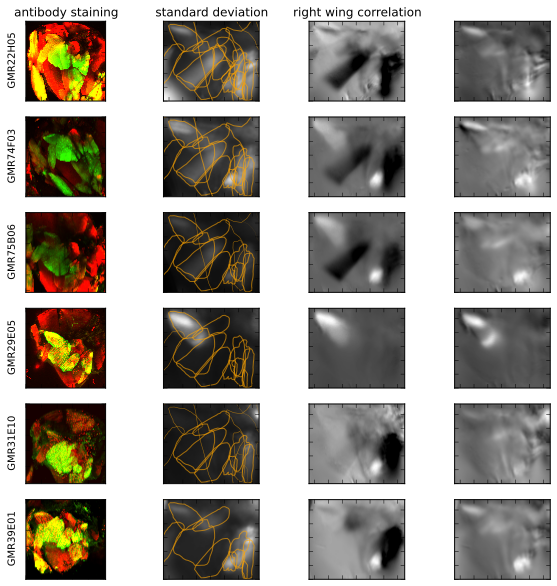

In [7]:
from matplotlib import gridspec

vmin = None#-20.5
vmax = None#20.5
xmin = 60
xmax = 750
xbounds = (xmin,xmax)
ymin = 325
ymax = 900
ybounds = (ymin,ymax)
fig = figure(figsize = (10,10))
gmrlines = ['GMR22H05','GMR74F03','GMR75B06','GMR29E05','GMR31E10','GMR39E01']
gs = gridspec.GridSpec(len(gmrlines), 4)
for i,line_name in enumerate(gmrlines):
    plot_pans = [subplot(gs[i,row]) for row in range(4)]
    if i == 0:
        axes(plot_pans[0])
        gca().set_title('antibody staining')
        axes(plot_pans[1])
        gca().set_title('standard deviation')
        axes(plot_pans[2])
        gca().set_title('right wing correlation')
        
    contour_kwargs = get_kwargs(line_name = line_name)
    plot_swarm_corr(gd.swarms[line_name],
                    contour_kwargs,
                    line_name = line_name,
                    plot_pans = plot_pans,
                    norm_vmin = None,norm_vmax = None,
                    cov_amp_vmin = None,cov_amp_vmax = None,
                    cov_freq_vmin = None,cov_freq_vmax = None,
                    xbounds = xbounds,ybounds = ybounds,
                    cmap = cm.gray)
    #savefig(line_name + '_corr' + '.pdf')
    #close()
savefig('correlations.pdf')

## summary stats on covariance data

In [8]:
def get_line_database(line_name):
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

def get_kwargs(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    contour_kwargs = dict()
    for key in get_muscle_list(line_name):
        if 'DVM' in key:
            contour_kwargs['DVM1'] = {'linewidth':line_database[ln]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM2'] = {'linewidth':line_database[ln]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM3'] = {'linewidth':line_database[ln]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
        else:
            contour_kwargs[key] = {'linewidth':line_database[ln][key]/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
    return contour_kwargs

In [9]:
#use the same model objects for all the flies
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

In [70]:
def get_group_fits(line_name,fit_subpix = False):
    """extract the image stats on a per muscle/per fly basis for all the flies in
    a genotyp - as given by line_name. if fit_subpix is true then only the data 
    within then mask will be fit """
    #get the list of muscles for a given line
    muscles = get_muscle_list(line_name)
    muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    print line_name
    #make a dictionary of lists to store the fits
    group_fits = {'dot_im_freq':{},
                'dot_im_amp':{},
                  'corr_im_freq':{},
                  'corr_im_amp':{},
                'norm_im':{}}
    #construct empty lists for each labeled muscle in a given genotype
    for gkey in group_fits:
        for m in muscles:
            group_fits[gkey][m] = list()
      
    for fly in gd.swarms[line_name].flies:
        #load the reference frame for the fly
        pkname = fly.fly_path + '/basis_fits.cpkl'
        fly_frame = mm.Frame();fly_frame.load(pkname)
        #load the stats file for the fly
        import os
        import cPickle
        stats_file_path = fly.fly_path + 'img_stats_df.cpkl'
        stats_file = open(stats_file_path)
        stats_data = cPickle.load(stats_file)
        stats_file.close()
        #get rid of any NAN or inf in the image
        norm_im = stats_data['rwing']['norm_img']
        norm_im[~isfinite(norm_im)] = 0
        
        dot_im_amp = stats_data['rwing']['dot_img']
        dot_im_amp[~isfinite(dot_im_amp)] = 0
        
        dot_im_freq = stats_data['freq']['dot_img']
        dot_im_freq[~isfinite(dot_im_freq)] = 0
        
        corr_im_amp = stats_data['rwing']['corr_img']*norm_im
        corr_im_amp[~isfinite(corr_im_amp)] = 0
        
        corr_im_freq = stats_data['freq']['corr_img']*norm_im
        corr_im_freq[~isfinite(corr_im_freq)] = 0
        

        
        #get the mask of all the muscles for fit
        masks = confocal_model.get_masks(fly_frame,shape(dot_im_amp))
        #create the model using only the muscles that express in a given line
        model = vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])
        fit_pix_mask = sum(model,axis=0) > 0
        #add a background term
        model = vstack([model,ones_like(masks[mask_key].ravel())])

        for im,im_key in zip([dot_im_amp,dot_im_freq,corr_im_amp,corr_im_freq,norm_im],
                ['dot_im_amp','dot_im_freq','corr_im_amp','corr_im_freq','norm_im']):
            if im_key == 'norm_im':
                from scipy.optimize import nnls
                if fit_subpix:
                    fits = nnls(model[:,fit_pix_mask].T,im.ravel()[fit_pix_mask])[0]
                else:
                    fits = nnls(model.T,im.ravel())[0]
                for m,fit in zip(muscles,fits):
                    group_fits[im_key][m].append(fit)
            else:
                if fit_subpix:
                    fits = dot(pinv(model[:,fit_pix_mask]).T,im.ravel()[fit_pix_mask])
                else:
                    fits = dot(pinv(model).T,im.ravel())
                for m,fit in zip(muscles,fits):
                    group_fits[im_key][m].append(fit)
    return group_fits

In [71]:
muscle_labels = ['DLM', 'DVM', 
                 'b1', 'b2', 'b3', 
                 'hg1', 'hg2', 'hg3', 'hg4', 
                 'i1', 'i2', 
                 'iii1', 'iii24', 'iii3', 
                 'nm', 'pr', 'ps', 'tpd', 'tpv', 'ttm']
grp_data = {'GcAMP':{},'GFP':{}}

for line_name in ['GMR22H05','GMR10A12','GMR74F03','GMR29E05','GMR31E10','GMR39E01']:#,'GMR10A12','GMR74F03','GMR29E05','GMR31E10','GMR39E01']:
    grp_data['GcAMP'][line_name] = get_group_fits(line_name,fit_subpix = True)

for line_name in ['GMR22H05_GFP','GMR31E10_GFP','GMR29E05_GFP']:#,'GMR10A12','GMR74F03','GMR29E05','GMR31E10','GMR39E01']:
    grp_data['GFP'][line_name] = get_group_fits(line_name,fit_subpix = True)

GMR22H05
GMR10A12
GMR74F03
GMR29E05
GMR31E10
GMR39E01
GMR22H05_GFP
GMR31E10_GFP
GMR29E05_GFP


In [13]:
import cPickle
f = open('cov_stats_grp_data.cpkl','wb')
cPickle.dump(grp_data,f)
f.close()

In [72]:
def plot_image_stat_quant(stat_key = 'dot_im_amp'):
    sp = 12
    for spacing,line_name in enumerate(['GMR22H05','GMR10A12','GMR74F03','GMR29E05','GMR31E10','GMR39E01']):    
        muscle_names = sorted(muscle_labels)
        for i,m in enumerate(muscle_labels):
            try:
                y = grp_data['GcAMP'][line_name][stat_key][m]
                errorbar(i*sp+spacing*0.05,mean(y),yerr=std(y)/sqrt(len(y)),color = 'k',alpha = 0.5,fmt ='o')
            except KeyError:
                #print 'no muscle ' + m
                pass

    for spacing,line_name in enumerate(['GMR22H05_GFP','GMR31E10_GFP','GMR29E05_GFP']):    
        muscle_names = sorted(muscle_labels)
        for i,m in enumerate(muscle_labels):
            try:
                y = grp_data['GFP'][line_name][stat_key][m]
                errorbar(i*sp+3+spacing*0.05,mean(y),yerr=std(y)/sqrt(len(y)),color = 'g',alpha = 0.5,fmt ='o')
            except KeyError:
                #print 'no muscle ' + m
                pass

    lbs =gca().set_xticks(range(0,len(muscle_labels)*sp,sp))
    nms =gca().set_xticklabels(muscle_labels,rotation='vertical')
    for x in range(0,len(muscle_labels)*sp,sp):
        axvspan(x-4, x+6, facecolor='b', alpha=0.05)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    gca().get_xaxis().tick_bottom()
    gca().get_yaxis().tick_left()
    savefig('%s_stats.pdf'%stat_key)

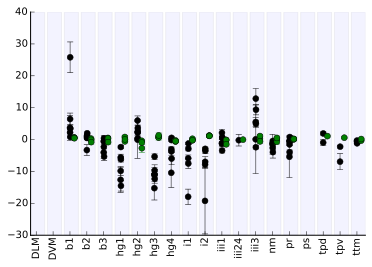

In [75]:
plot_image_stat_quant(stat_key = 'corr_im_amp')

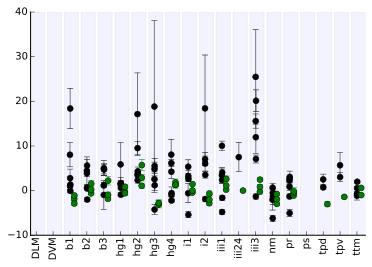

In [76]:
plot_image_stat_quant(stat_key = 'corr_im_freq')

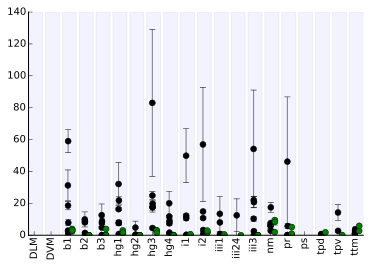

In [77]:
plot_image_stat_quant(stat_key = 'norm_im')

## Interpolated dF/F movies

In [5]:
#GMR22H05_swarm 
#GMR39E01_swarm
#GMR31E10_swarm
#GMR29E05_swarm

#GMR22H05_GFP_swarm = flylib.Squadron(fly_db,GMR22H05_GFP_list)

#GMR31E10_GFP_swarm = flylib.Squadron(fly_db,GMR31E10_GFP_list)

#GMR29E05_GFP_swarm = flylib.Squadron(fly_db,GMR29E05_GFP_list)

In [5]:
def get_data(fly):
    #this function interpolates a movie for each trial and returns the data as a dictionary
    expmnt = fly.experiments.values()[0]
    sigs = expmnt.exp_record['tiff_data']['axon_framebase']
    trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
    imgs = expmnt.exp_record['tiff_data']['images']
    def get_resamp_imgs(cond):
        cond_idxs = [t for t in trials if gd.get_cond(fly,t) == gd.encode[cond]]
        img_sequences = [np.array(imgs[t[0]:t[-1]]) for t in cond_idxs]
        img_times = [np.array(sigs['times'][t[0]:t[-1]])-sigs['times'][t[0]] for t in cond_idxs]
        scond_sequences =  [np.array(sigs['StimCond'][t[0]:t[-1]]) for t in cond_idxs]
        resampled_img_sequences = list()
        resampled_scond_sequences = list()
        from scipy.interpolate import interp1d
        for tms,seq,scond in zip(img_times,img_sequences,scond_sequences):
            fx = interp1d(tms,seq,axis = 0)
            sc = interp1d(tms,scond,axis =0)
            resample_times = np.arange(0,23,0.03)
            resampled_img_sequences.append(fx(resample_times))
            resampled_scond_sequences.append(sc(resample_times))
        return resampled_img_sequences,resampled_scond_sequences
    movie_dict = dict()
    #scond_dict = dict()
    for cond in gd.encode.keys():
        print cond
        resampled_img_sequences,resampled_scond_sequences = get_resamp_imgs(cond)
        movie_dict[cond] = np.mean(resampled_img_sequences,axis = 0)
        #scond_dict[cond] = np.mean(resampled_scond_sequences,axis = 0)
    return movie_dict

In [6]:
ls /media/FlyDataC/FlyDB/Fly0425

basis_fits.cpkl  epoch_data.cpkl  fly_record.hdf5  img_stats_df.cpkl  note.txt


In [14]:
def get_data_DF_F(fly_path):
    fly_path = fly_path
    import h5py
    import flylib
    import group_data as gd
    import numpy as np
    import os
    #this function interpolates a movie for each trial and returns the data as a dictionary
    fly_record = h5py.File(fly_path + 'fly_record.hdf5','r')
    exp_record = fly_record['experiments'].values()[0]
    sigs = exp_record['tiff_data']['axon_framebase']
    trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
    imgs = exp_record['tiff_data']['images']
    f = open(fly_path + 'epoch_data.cpkl')
    import cPickle
    baseline_range = cPickle.load(f)['baseline_F']
    f.close()
    F = np.mean(imgs[baseline_range],axis = 0)
    def get_resamp_imgs(cond):
        cond_idxs = list()
        for t in trials:
            try:
                if gd.get_cond(fly_path,t) == gd.encode[cond]:
                    cond_idxs.append(t)
            except ValueError:
                pass
        #cond_idxs = [t for t in trials if gd.get_cond(fly_path,t) == gd.encode[cond]]
        
        img_sequences = [np.array(imgs[t[0]:t[-1]]) for t in cond_idxs]
        img_times = [np.array(sigs['times'][t[0]:t[-1]])-sigs['times'][t[0]] for t in cond_idxs]
        scond_sequences =  [np.array(sigs['StimCond'][t[0]:t[-1]]) for t in cond_idxs]
        rwing_sequences =  [np.array(sigs['Ph1'][t[0]:t[-1]]) for t in cond_idxs]
        freq_sequences = [np.array(sigs['wb_frequency'][t[0]:t[-1]]) for t in cond_idxs]
        
        resampled_img_sequences = list()
        resampled_scond_sequences = list()
        resampled_rwing_sequences = list()
        resampled_freq_sequences = list()
        
        from scipy.interpolate import interp1d
        for tms,seq,scond,rwing,freq in zip(img_times,
                                       img_sequences,
                                       scond_sequences,
                                       rwing_sequences,
                                       freq_sequences):
            fx = interp1d(tms,seq,axis = 0)
            sx = interp1d(tms,scond,axis =0)
            rx = interp1d(tms,rwing,axis =0)
            qx = interp1d(tms,freq,axis = 0)
            resample_times = np.arange(0,23,1/45.0)
            
            img_seq = (fx(resample_times)-F)/F
            img_seq[~np.isfinite(img_seq)] = 0
            
            resampled_img_sequences.append(img_seq)
            resampled_scond_sequences.append(sx(resample_times))
            resampled_rwing_sequences.append(rx(resample_times))
            resampled_freq_sequences.append(qx(resample_times))
        return resampled_img_sequences,resampled_scond_sequences,resampled_rwing_sequences,resampled_freq_sequences
    
    #movie_dict = dict()
    #scond_dict = dict()
    #rwing_dict = dict()
    #freq_dict = dict() 
    if os.path.isfile(fly_path + 'resampled_sequences.hdf5'):
        os.remove(fly_path + 'resampled_sequences.hdf5')
    interp_file = h5py.File(fly_path + 'resampled_sequences.hdf5','a')
    for cond in gd.encode.keys():
        h5group = interp_file.create_group(cond)
        resampled_img_sequences,resampled_scond_sequences,resampled_rwing_sequences,resampled_freq_sequences = get_resamp_imgs(cond)
        h5group.create_dataset('movie_data',data = np.mean(resampled_img_sequences,axis = 0),compression="gzip", compression_opts=5)
        #scond_dict[cond] = resampled_scond_sequences
        h5group.create_dataset('stim_data',data = np.mean(resampled_scond_sequences,axis = 0),compression="gzip", compression_opts=5)
        #rwing_dict[cond] = resampled_rwing_sequences
        h5group.create_dataset('rwing_data',data = np.mean(resampled_rwing_sequences,axis = 0),compression="gzip", compression_opts=5)
        #freq_dict[cond] = resampled_freq_sequences
        h5group.create_dataset('freq_data',data = np.mean(resampled_freq_sequences,axis = 0),compression="gzip", compression_opts=5)
        #movie_dict[cond] = np.mean(resampled_img_sequences,axis = 0)
        #scond_dict[cond] = np.mean(resampled_scond_sequences,axis = 0)
        #rwing_dict[cond] = np.mean(resampled_rwing_sequences,axis = 0)
        #freq_dict[cond] = np.mean(resampled_freq_sequences,axis = 0)
    interp_file.flush()
    interp_file.close()
    #fly_num = fly_path.split('/')[-2]
    #save_dict = {fly_num:{'movie_dict':movie_dict,
    #                 'scond_dict':scond_dict,
    #                 'rwing_dict':rwing_dict,
    #                 'freq_dict':freq_dict}}
    

In [15]:
import os
rootpath = '/media/FlyDataC/FlyDB/Fly%04d/'
GMR22H05_list = [308,309,310,311,312,314,315,316,317,327,328] #range(317,326)
#GMR22H05_list = [308,309,310,311,312,313,314,315,316,317,327,328] #range(317,326)
GMR39E01_list = [318,319,320,321,322,323,324,325,329,330,331,332,333,334,335,336]
GMR31E10_list = [337,338,339,340,341,342,343,344,345,346,347,348]
GMR29E05_list = [349,350,351,352,353,354,355,356,357,358,359,360]
GMR10A12_list = [387,388,389,399,400,401,408,409,410,417,418,419]
GMR75B06_list = [393,394,395,402,403,404,405,406,407,420,421,422]
GMR74F03_list = [396,397,398,411,412,413,414,415,416]

In [16]:
#movie_data,cond_data,wing_data,freq_data = get_data_DF_F(fly_paths[0])

In [19]:
#flylist = GMR22H05_list + GMR22H05_list + GMR31E10_list
flylist = GMR29E05_list + GMR10A12_list + GMR75B06_list + GMR74F03_list
fly_paths = [rootpath%fly_num for fly_num in flylist]
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [20]:
results = v.map(get_data_DF_F, fly_paths)

## dimensionality reduction (least squares)

In [1]:
#fit to each fly in seraial (block) but break up the data to run in parallel within a fly.
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [2]:
import os
rootpath = '/media/FlyDataC/FlyDB/Fly%04d/'
GMR22H05_list = [308,309,310,311,312,314,315,316,317,327,328] #range(317,326)
#GMR22H05_list = [308,309,310,311,312,313,314,315,316,317,327,328] #range(317,326)
GMR39E01_list = [318,319,320,321,322,323,324,325,329,330,331,332,333,334,335,336]
GMR31E10_list = [337,338,339,340,341,342,343,344,345,346,347,348]
GMR29E05_list = [349,350,351,352,353,354,355,356,357,358,359,360]
GMR10A12_list = [387,388,389,399,400,401,408,409,410,417,418,419]
GMR75B06_list = [393,394,395,402,403,404,405,406,407,420,421,422]
GMR74F03_list = [396,397,398,411,412,413,414,415,416]

groups = {'GMR22H05':GMR22H05_list,
          'GMR39E01':GMR39E01_list,
          'GMR31E10':GMR31E10_list,
          'GMR29E05':GMR29E05_list,
          'GMR10A12':GMR10A12_list,
          'GMR75B06':GMR75B06_list,
          'GMR74F03':GMR74F03_list}
fly_paths = list()
for key in groups.keys():
    for fly_num in groups[key]:
        fly_paths.append((rootpath%fly_num,key))

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

In [4]:
def get_line_database(line_name):
    print line_name
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

def fit_to_model(imchunk,model, mode = 'pinv',fit_pix_mask = None,baseline = None):
    import numpy as np
    im_array = (imchunk-baseline)/baseline
    imshape = np.shape(im_array[0])
    im_array = im_array.reshape((-1,imshape[0]*imshape[1]))
    if mode == 'nnls':
        fits = np.empty((np.shape(model)[0],np.shape(im_array)[0]))
        for i,im in enumerate(im_array):
            from scipy.optimize import nnls
            if not(fit_pix_mask is None):
                fits[:,i] = nnls(model[:,fit_pix_mask].T,im[fit_pix_mask])[0]
            else:
                fits[:,i] = nnls(model.T,im)[0]
    else:
        im = im_array
        print np.shape(im_array)
        from numpy.linalg import pinv
        if not(fit_pix_mask is None):
            fits = np.dot(pinv(model[:,fit_pix_mask]).T,im[:,fit_pix_mask].T)
        else:
            fits = np.dot(pinv(model).T,im)
    return fits

#extract the data give the fly_path and 'line_name'
def extract_signals(fly_path,line_name):
    import muscle_model as mm
    import numpy as np
    import h5py
    confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
    confocal_view = mm.ModelViewMPL(confocal_model)
    #first create the model for the fly
    #get the list of muscles for a given line
    muscles = get_muscle_list(line_name)
    muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    #get a reference to the image data
    fly_record = h5py.File(fly_path + 'fly_record.hdf5','r')
    exp_record = fly_record['experiments'].values()[0]
    imgs = exp_record['tiff_data']['images']
    #construct the model for a fly
    import os
    import cPickle
    pkname = fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)    
    #get the mask of all the muscles for fit
    masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
    #create the model using only the muscles that express in a given line
    model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])
    fit_pix_mask = np.sum(model,axis=0) > 0
    #add a background term
    ####model = np.vstack([model,np.ones_like(masks[mask_key].ravel())])
    #plb.imshow(np.sum(model,axis = 0).reshape(np.shape(imgs[0])),cmap = plb.cm.gray)
    
    ##subtract baseline epoch from each image
    f = open(fly_path + 'epoch_data.cpkl')
    import cPickle
    baseline_range = cPickle.load(f)['baseline_F']
    f.close()
    baseln = np.mean(imgs[baseline_range],axis = 0)
    
    chnk_sz = 2000
    num_samps = np.shape(imgs)[0]
    chunks = [slice(x,x+chnk_sz if x+chnk_sz < num_samps else num_samps) for x in range(0,num_samps,chnk_sz)]
    
    img_chunks = [np.array(imgs[chunk]) for chunk in chunks]
    models = [model for chunk in chunks]
    modes = ['nnls' for chunk in chunks]
    fit_pix_masks = [fit_pix_mask for chunk in chunks]
    baselines = [baseln for chunk in chunks]
    
    fits = v.map(fit_to_model,img_chunks,models,modes,fit_pix_masks,baselines)
    #fit = fit_to_model(imchunk,model,mode = 'nnls',fit_pix_mask = fit_pix_mask)
    return fits,muscles

In [5]:
import numpy as np
for fly_path in fly_paths:
    print fly_path[0]
    fits,muscles = extract_signals(*fly_path)
    f = open(fly_path[0]+'nnls_fits_no_bk_dF_F.cpkl','wb')
    import cPickle as cpkl
    cpkl.dump({'fits':np.hstack(fits),'muscles':muscles},f)
    f.close()

/media/FlyDataC/FlyDB/Fly0337/
GMR31E10
/media/FlyDataC/FlyDB/Fly0338/
GMR31E10
/media/FlyDataC/FlyDB/Fly0339/
GMR31E10
/media/FlyDataC/FlyDB/Fly0340/
GMR31E10
/media/FlyDataC/FlyDB/Fly0341/
GMR31E10
/media/FlyDataC/FlyDB/Fly0342/
GMR31E10
/media/FlyDataC/FlyDB/Fly0343/
GMR31E10
/media/FlyDataC/FlyDB/Fly0344/
GMR31E10
/media/FlyDataC/FlyDB/Fly0345/
GMR31E10
/media/FlyDataC/FlyDB/Fly0346/
GMR31E10
/media/FlyDataC/FlyDB/Fly0347/
GMR31E10
/media/FlyDataC/FlyDB/Fly0348/
GMR31E10
/media/FlyDataC/FlyDB/Fly0308/
GMR22H05
/media/FlyDataC/FlyDB/Fly0309/
GMR22H05
/media/FlyDataC/FlyDB/Fly0310/
GMR22H05
/media/FlyDataC/FlyDB/Fly0311/
GMR22H05
/media/FlyDataC/FlyDB/Fly0312/
GMR22H05
/media/FlyDataC/FlyDB/Fly0314/
GMR22H05
/media/FlyDataC/FlyDB/Fly0315/
GMR22H05
/media/FlyDataC/FlyDB/Fly0316/
GMR22H05
/media/FlyDataC/FlyDB/Fly0317/
GMR22H05
/media/FlyDataC/FlyDB/Fly0327/
GMR22H05
/media/FlyDataC/FlyDB/Fly0328/
GMR22H05
/media/FlyDataC/FlyDB/Fly0318/
GMR39E01
/media/FlyDataC/FlyDB/Fly0319/
GMR39E01


In [6]:
import smtplib
server = smtplib.SMTP( "smtp.gmail.com", 587 )
server.starttls()
server.login( 'thlindsay1@gmail.com', 'cyp4501a1' )
server.sendmail( 'test', '5412229957@txt.att.net', 'batch processing done' )

{}

In [86]:
f = open(fly_paths[21][0]+'nnls_fits_no_bk_dF_F.cpkl','rb')
data = cpkl.load(f)

## Plot extracted data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pylab as plb

In [4]:
import os
rootpath = '/media/FlyDataC/FlyDB/Fly%04d/'
GMR22H05_list = [308,309,310,311,312,314,315,316,317,327,328] #range(317,326)
#GMR22H05_list = [308,309,310,311,312,313,314,315,316,317,327,328] #range(317,326)
GMR39E01_list = [318,319,320,321,322,323,324,325,329,330,331,332,333,334,335,336]
GMR31E10_list = [337,338,339,340,341,342,343,344,345,346,347,348]
GMR29E05_list = [349,350,351,352,353,354,355,356,357,358,359,360]
GMR10A12_list = [387,388,389,399,400,401,408,409,410,417,418,419]
GMR75B06_list = [393,394,395,402,403,404,405,406,407,420,421,422]
GMR74F03_list = [396,397,398,411,412,413,414,415,416]

groups = {'GMR22H05':GMR22H05_list,
          'GMR39E01':GMR39E01_list,
          'GMR31E10':GMR31E10_list,
          'GMR29E05':GMR29E05_list,
          'GMR10A12':GMR10A12_list,
          'GMR75B06':GMR75B06_list,
          'GMR74F03':GMR74F03_list}
swarm_data = dict()
for key in groups.keys():
    paths = dict()
    for fly_num in groups[key]:
        paths[fly_num] = {'fly_path':rootpath%fly_num,'fly_num':fly_num}
    swarm_data[key] = paths 

In [5]:
def get_signal_dict(fly_path):
    import h5py
    import cPickle
    import numpy as np
    muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
    fly_record_file = fly_path+'fly_record.hdf5'
    signal_dict = dict()
    fi = open(muscle_data_file,'rb')
    muscle_data = cPickle.load(fi)
    fi.close()
    for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
        signal_dict[mu] = sig
    hf = h5py.File(fly_record_file,'r')
    exp_record = hf['experiments'].values()[0]
    for key in exp_record['tiff_data']['axon_framebase'].keys():
        signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
    hf.close()
    return signal_dict

In [6]:
for swarm in swarm_data.values():
    for fly in swarm.values():
        #print fly['fly_num']
        fly['sigs'] = get_signal_dict(fly['fly_path'])

In [7]:
def make_sig_mtrx(fly_dict):
    sigs = fly_dict['sigs']
    fly_path = fly_dict['fly_path']
    import flylib
    trials = flylib.idx_by_thresh(sigs['StimCond'],-0.0)
    import group_data as gd
    from scipy.interpolate import griddata
    import numpy as np

    signal_mtrxs = dict()
    for key in sigs:
        signal_mtrxs[key] = list()
    signal_mtrxs['trial_cond'] = list()
    signal_mtrxs['fly_num'] = list()

    for trial in trials:
        try:
            cond = gd.get_cond(fly_path,trial)
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            xi = np.linspace(0,23,1150)
            #signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['trial_cond'].append(cond)
            for skey in sigs.keys():#['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError'
    for key in signal_mtrxs:
        signal_mtrxs[key] = np.array(signal_mtrxs[key])
    return signal_mtrxs

In [8]:
for swarm in swarm_data.values():
    for fly_dict in swarm.values():
        #print fly_dict['fly_num']
        fly_dict['sig_mtrx'] = make_sig_mtrx(fly_dict)

/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:445: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


ValueError
ValueError
ValueError
ValueError


## make intro figure

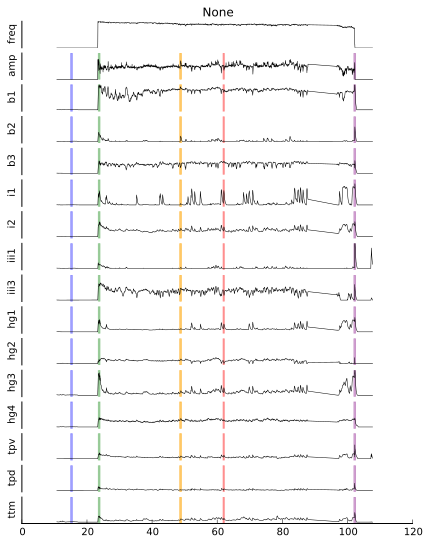

In [9]:
import numpy as np
fig = plb.figure(figsize = (7,9))
slist = ['GMR22H05','GMR39E01','GMR31E10','GMR29E05','GMR10A12','GMR75B06','GMR74F03']

plot_sigs = ['wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

from matplotlib.gridspec import GridSpec
gs = GridSpec(len(plot_sigs),1)
plotpans = [plb.subplot(gs[i,0]) for i in range(len(plot_sigs))]

def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    plb.gca().set_ybound(-0.1,1.8)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(plot_sigs)-1):
        plb.gca().spines['bottom'].set_visible(True)
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    if (r == 0):
        plb.gca().set_title(col)
    if ('amp' in row):
        plb.gca().set_ybound(0,90)
    if ('freq' in row):
        plb.gca().set_ybound(0,250)

#swm = slist[1]
#fly_idx = 5

swm = slist[0]
fly_idx = 1

rng2 = slice(30850-500,30850)
rng1 = slice(0,4000)

rng2 = np.arange(30850-500,30850)
rng1 = np.arange(0,3500)

trng = np.hstack((rng1,rng2))
times = swarm_data[swm].values()[fly_idx]['sigs']['times'][np.hstack((rng1,rng2-rng2[0]+rng1[-1]+400))]
flight_mask = swarm_data[swm].values()[fly_idx]['sigs']['wb_frequency'][trng] > 20
import numpy as np
kwargs = {'color':'k','lw':0.5}

hlt_rng0 = [15,15.5]
hlt_rng1 = [23.5,24]
hlt_rng2 = [48.5,49]
hlt_rng3 = [61.8,62.2]
hlt_rng4 = [102,102.5]

for i,pp,sig in zip(range(len(plot_sigs)),plotpans,plot_sigs):
    plb.axes(pp)
    if 'Ph1' in sig:
        plb.plot(times,np.rad2deg(swarm_data[swm].values()[fly_idx]['sigs'][sig][trng]/5.0)*flight_mask,**kwargs)
        frmt_axis(i,0,'amp',None)
        plb.axvspan(hlt_rng0[0],hlt_rng0[1],alpha = 0.3,color = 'b')
        plb.axvspan(hlt_rng1[0],hlt_rng1[1],alpha = 0.3,color = 'g')
        plb.axvspan(hlt_rng2[0],hlt_rng2[1],alpha = 0.5,color = 'orange')
        plb.axvspan(hlt_rng3[0],hlt_rng3[1],alpha = 0.3,color = 'r')
        plb.axvspan(hlt_rng4[0],hlt_rng4[1],alpha = 0.3,color = 'purple')
        
    elif 'wb_frequency' in sig:
        plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
        frmt_axis(i,0,'freq',None)
    else:
        try:
            plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
            frmt_axis(i,0,sig,None)
            plb.axvspan(hlt_rng0[0],hlt_rng0[1],alpha = 0.3,color = 'b')
            plb.axvspan(hlt_rng1[0],hlt_rng1[1],alpha = 0.3,color = 'g')
            plb.axvspan(hlt_rng2[0],hlt_rng2[1],alpha = 0.5,color = 'orange')
            plb.axvspan(hlt_rng3[0],hlt_rng3[1],alpha = 0.3,color = 'r')
            plb.axvspan(hlt_rng4[0],hlt_rng4[1],alpha = 0.3,color = 'purple')
        except KeyError:
            print i
        
plb.savefig('intro_trace_broad.pdf')

In [10]:
def get_line_database(line_name):
    print line_name
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

fly_path = swarm_data[swm].values()[fly_idx]['fly_path']
import os
import cPickle
import muscle_model as mm
import numpy as np
import h5py

line_name = swm
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)
#get a reference to the image data
fly_record = h5py.File(fly_path + 'fly_record.hdf5','r')
exp_record = fly_record['experiments'].values()[0]
imgs = exp_record['tiff_data']['images']
#first create the model for the fly
#get the list of muscles for a given line
muscles = get_muscle_list(line_name)
muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]

pkname = fly_path + '/basis_fits.cpkl'
fly_frame = mm.Frame();fly_frame.load(pkname)    
#get the mask of all the muscles for fit
masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
#create the model using only the muscles that express in a given line
model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])

##get the baseline epoch

f = open(fly_path + 'epoch_data.cpkl')
import cPickle
baseline_range = cPickle.load(f)['baseline_F']
f.close()
baseln = np.mean(imgs[baseline_range],axis = 0)

GMR22H05


In [11]:
#reconstruct the fit vector
fits_reconst = np.array([swarm_data[swm].values()[fly_idx]['sigs'][m] for m in muscles])

In [12]:
def warp_fly_image(fly_path,img,s = 1):
    import cv2
    import cPickle
    pkname = fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

[30614 30615 30616]


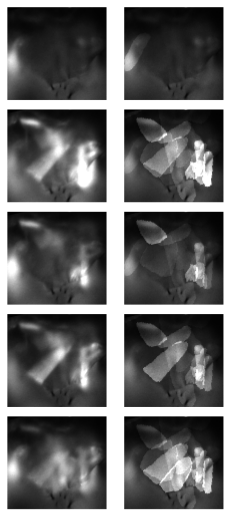

In [13]:
fig = plb.figure(figsize = (4,9))
def kill_spines():
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    plb.gca().set_ybound(275,1024)
    plb.gca().set_xbound(0,800)

import muscle_model as mm
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)


gamma = lambda x: x**1.6
vmax = gamma(70)

from matplotlib.gridspec import GridSpec
hlt_rngs = [hlt_rng0,hlt_rng1,hlt_rng2,hlt_rng3,hlt_rng4]
gs = GridSpec(len(hlt_rngs),2)
#example_pannels = [plb.subplot(gs[i,0]) for i in range(4)]


def plot_example_pannel(hlt_idx):
    hlt_rng = hlt_rngs[hlt_idx]
    if hlt_idx < 4:
        rng = np.squeeze(np.argwhere((times > hlt_rng[0]) & (times < hlt_rng[1])))
    else:
        rng = np.arange(30600,
                        30620).astype(np.int)
        print rng[-6:-3]
    #plb.figure(figsize = (7,9))
    plb.subplot(gs[hlt_idx,0])
    real_img = gamma(np.mean(imgs[rng[-6]:rng[-4]],axis=0))
    #real_img = gamma(imgs[rng[-6]:rng[-3]])
    real_img = warp_fly_image(fly_path,real_img)
    model_img = gamma((np.dot(model.T,fits_reconst[:,rng[10]]).reshape(np.shape(imgs[0]))*baseln)+baseln)
    model_img = warp_fly_image(fly_path,model_img)
    
    plb.imshow(real_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
    kill_spines()
    plb.subplot(gs[hlt_idx,1])
    plb.imshow(model_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
    kill_spines()

for idx in range(5):
    plot_example_pannel(idx)
    
plb.gcf().subplots_adjust(hspace = 0.1,wspace = 0.1)
plb.savefig('introimgs.pdf')

### Movie of example figure

In [ ]:
import numpy as np
fig = plb.figure(figsize = (13,6))
slist = ['GMR22H05','GMR39E01','GMR31E10','GMR29E05','GMR10A12','GMR75B06','GMR74F03']

plot_sigs = ['wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

from matplotlib.gridspec import GridSpec
gs = GridSpec(len(plot_sigs),5)
plotpans = [plb.subplot(gs[i,2:]) for i in range(len(plot_sigs))]

gamma = lambda x: x**1.6
vmax = gamma(80)

def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    plb.gca().set_ybound(-0.1,1.8)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(plot_sigs)-1):
        plb.gca().spines['bottom'].set_visible(True)
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    if (r == 0):
        plb.gca().set_title(col)
    if ('amp' in row):
        plb.gca().set_ybound(0,90)
    if ('freq' in row):
        plb.gca().set_ybound(0,250)
    plb.gca().set_xbound(10,90)

def kill_spines():
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    plb.gca().set_ybound(275,1024)
    plb.gca().set_xbound(0,800)
    
#swm = slist[1]
#fly_idx = 5

swm = slist[0]
fly_idx = 1

rng1 = np.arange(0,3500)

trng = rng1# np.hstack((rng1,rng2))
times = swarm_data[swm].values()[fly_idx]['sigs']['times'][rng1]
flight_mask = swarm_data[swm].values()[fly_idx]['sigs']['wb_frequency'][trng] > 20
import numpy as np
kwargs = {'color':'k','lw':0.5}

#hlt_rng = [15,15.5]
hlt_rng = [0.0,0.2]
#hlt_rng2 = [48.5,49]
#hlt_rng3 = [61.8,62.2]
#hlt_rng4 = [102,102.5]
patch_list = list()
for i,pp,sig in zip(range(len(plot_sigs)),plotpans,plot_sigs):
    plb.axes(pp)
    if 'Ph1' in sig:
        plb.plot(times,np.rad2deg(swarm_data[swm].values()[fly_idx]['sigs'][sig][trng]/5.0)*flight_mask,**kwargs)
        patch_list.append(plb.axvspan(hlt_rng[0],hlt_rng[1],alpha = 0.3,color = 'b'))
        frmt_axis(i,0,'amp',None)

    elif 'wb_frequency' in sig:
        plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
        patch_list.append(plb.axvspan(hlt_rng[0],hlt_rng[1],alpha = 0.3,color = 'b'))
        frmt_axis(i,0,'freq',None)
    else:
        try:
            plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
            patch_list.append(plb.axvspan(hlt_rng[0],hlt_rng[1],alpha = 0.3,color = 'b'))
            frmt_axis(i,0,sig,None)
        except KeyError:
            print i

img_idx = np.squeeze(np.argwhere(times>hlt_rng[0]))[0]

data_plot = plb.subplot(gs[:len(plot_sigs)/2,:2])
data_img = gamma(imgs[img_idx])
data_img = warp_fly_image(fly_path,data_img)
data_img_handle = plb.imshow(data_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()

model_plot = plb.subplot(gs[len(plot_sigs)/2:,:2])
model_img = gamma((np.dot(model.T,fits_reconst[:,img_idx]).reshape(np.shape(imgs[0]))*baseln)+baseln)
model_img = warp_fly_image(fly_path,model_img)
model_img_handle = plb.imshow(model_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()

ptch_start = patch_list[0].xy[:,0].copy()

def update_fig(t):
    img_idx = np.squeeze(np.argwhere(times>t))[0]
    for ptch in patch_list:
        ptch.xy[:,0] = ptch_start+t
    data_img = gamma(imgs[img_idx])
    data_img = warp_fly_image(fly_path,data_img)
    data_img_handle.set_data(data_img)

    model_img = gamma((np.dot(model.T,fits_reconst[:,img_idx]).reshape(np.shape(imgs[0]))*baseln)+baseln)
    model_img = warp_fly_image(fly_path,model_img)
    model_img_handle.set_data(model_img)

update_fig(15.0)

import matplotlib.animation as animation
writer = Writer(fps=45, metadata=dict(artist='Me'), bitrate=1800)
ani = animation.FuncAnimation(fig, update_fig, frames=np.arange(15.0,85.0,1/30.0), blit=False, interval = 33)
ani.save('test.mp4', writer=writer)

In [34]:
patch_list[0].xy

array([[ 87.86666667,   0.        ],
       [ 87.86666667,   1.        ],
       [ 88.06666667,   1.        ],
       [ 88.06666667,   0.        ],
       [ 87.86666667,   0.        ]])

In [29]:
ptch_start

array([ 494.5,  494.5,  494.7,  494.7,  494.5])

### Example traces for "sparce" line

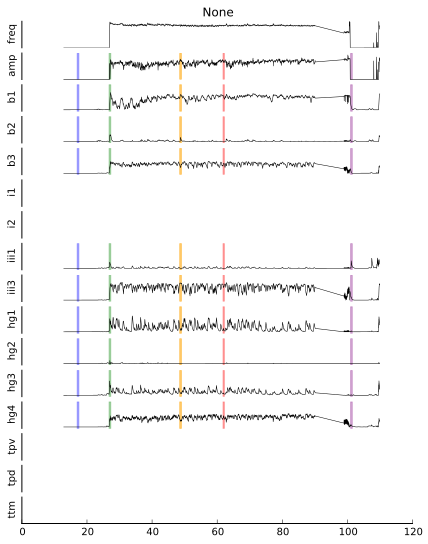

In [18]:
import numpy as np
fig = plb.figure(figsize = (7,9))
slist = ['GMR22H05','GMR39E01','GMR31E10','GMR29E05','GMR10A12','GMR75B06','GMR74F03']

plot_sigs = ['wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

from matplotlib.gridspec import GridSpec
gs = GridSpec(len(plot_sigs),1)
plotpans = [plb.subplot(gs[i,0]) for i in range(len(plot_sigs))]

def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    plb.gca().set_ybound(-0.1,1.8)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(plot_sigs)-1):
        plb.gca().spines['bottom'].set_visible(True)
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    if (r == 0):
        plb.gca().set_title(col)
    if ('amp' in row):
        plb.gca().set_ybound(0,90)
    if ('freq' in row):
        plb.gca().set_ybound(0,250)

swm = slist[1]
#fly_idx = 8
fly_idx = 9
#swm = slist[0]
#fly_idx = 1

#rng2 = slice(30850-500,30850)
#rng1 = slice(0,4000)

rng2 = np.arange(57450-500,57450)
rng1 = np.arange(300,3500+300)

trng = np.hstack((rng1,rng2))
times = swarm_data[swm].values()[fly_idx]['sigs']['times'][np.hstack((rng1,rng2-rng2[0]+rng1[-1]+400))]
flight_mask = swarm_data[swm].values()[fly_idx]['sigs']['wb_frequency'][trng] > 20
import numpy as np
kwargs = {'color':'k','lw':0.5}

hlt_rng0 = [17,17.5]
hlt_rng1 = [26.8,27.3]
hlt_rng2 = [48.5,49]
hlt_rng3 = [61.8,62.2]
hlt_rng4 = [101,101.5]

for i,pp,sig in zip(range(len(plot_sigs)),plotpans,plot_sigs):
    plb.axes(pp)
    if 'Ph1' in sig:
        plb.plot(times,np.rad2deg(swarm_data[swm].values()[fly_idx]['sigs'][sig][trng]/5.0)*flight_mask,**kwargs)
        frmt_axis(i,0,'amp',None)
        plb.axvspan(hlt_rng0[0],hlt_rng0[1],alpha = 0.3,color = 'b')
        plb.axvspan(hlt_rng1[0],hlt_rng1[1],alpha = 0.3,color = 'g')
        plb.axvspan(hlt_rng2[0],hlt_rng2[1],alpha = 0.5,color = 'orange')
        plb.axvspan(hlt_rng3[0],hlt_rng3[1],alpha = 0.3,color = 'r')
        plb.axvspan(hlt_rng4[0],hlt_rng4[1],alpha = 0.3,color = 'purple')
        
    elif 'wb_frequency' in sig:
        plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
        frmt_axis(i,0,'freq',None)
    else:
        try:
            plb.plot(times,swarm_data[swm].values()[fly_idx]['sigs'][sig][trng],**kwargs)
            
            plb.axvspan(hlt_rng0[0],hlt_rng0[1],alpha = 0.3,color = 'b')
            plb.axvspan(hlt_rng1[0],hlt_rng1[1],alpha = 0.3,color = 'g')
            plb.axvspan(hlt_rng2[0],hlt_rng2[1],alpha = 0.5,color = 'orange')
            plb.axvspan(hlt_rng3[0],hlt_rng3[1],alpha = 0.3,color = 'r')
            plb.axvspan(hlt_rng4[0],hlt_rng4[1],alpha = 0.3,color = 'purple')
        except KeyError:
            plb.plot(times,np.ones_like(times),lw = 0)
            #frmt_axis(i,0,'freq',None)
        frmt_axis(i,0,sig,None)
        
plb.savefig('intro_trace_sparse.pdf')

GMR39E01


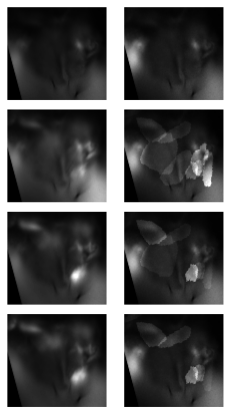

In [20]:
def get_line_database(line_name):
    print line_name
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

fly_path = swarm_data[swm].values()[fly_idx]['fly_path']
import os
import cPickle
import muscle_model as mm
import numpy as np
import h5py

line_name = swm
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)
#get a reference to the image data
fly_record = h5py.File(fly_path + 'fly_record.hdf5','r')
exp_record = fly_record['experiments'].values()[0]
imgs = exp_record['tiff_data']['images']
#first create the model for the fly
#get the list of muscles for a given line
muscles = get_muscle_list(line_name)
muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]

pkname = fly_path + '/basis_fits.cpkl'
fly_frame = mm.Frame();fly_frame.load(pkname)    
#get the mask of all the muscles for fit
masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
#create the model using only the muscles that express in a given line
model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])

##get the baseline epoch

f = open(fly_path + 'epoch_data.cpkl')
import cPickle
baseline_range = cPickle.load(f)['baseline_F']
f.close()
baseln = np.mean(imgs[baseline_range],axis = 0)


fits_reconst = list()
for m in muscles:
    try:
        fits_reconst.append(swarm_data[swm].values()[fly_idx]['sigs'][m])
    except KeyError:
        pass
fits_reconst = np.array(fits_reconst)   

#np.array([swarm_data[swm].values()[fly_idx]['sigs'][m] for m in muscles])
fig = plb.figure(figsize = (4,9))
def kill_spines():
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    plb.gca().set_ybound(275,1024)
    plb.gca().set_xbound(0,800)

import muscle_model as mm
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)


gamma = lambda x: x**1.6
vmax = gamma(60)

from matplotlib.gridspec import GridSpec
hlt_rngs = [hlt_rng0,hlt_rng1,hlt_rng2,hlt_rng3,hlt_rng4]
gs = GridSpec(len(hlt_rngs),2)
#example_pannels = [plb.subplot(gs[i,0]) for i in range(4)]


def plot_example_pannel(hlt_idx):
    hlt_rng = hlt_rngs[hlt_idx]
    rng = np.argwhere((times > hlt_rng[0]) & (times < hlt_rng[1]))+300
    #plb.figure(figsize = (7,9))
    plb.subplot(gs[hlt_idx,0])
    
    real_img = gamma(np.mean(imgs[rng[0]:rng[-1]],axis=0))
    real_img = warp_fly_image(fly_path,real_img)
    model_img = gamma((np.dot(model.T,fits_reconst[:,rng[10]]).reshape(np.shape(imgs[0]))*baseln)+baseln)
    model_img = warp_fly_image(fly_path,model_img)
    
    plb.imshow(real_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
    kill_spines()
    plb.subplot(gs[hlt_idx,1])
    plb.imshow(model_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
    kill_spines()

for idx in range(4):
    plot_example_pannel(idx)
    
plb.gcf().subplots_adjust(hspace = 0.1,wspace = 0.1)
#plb.savefig('introimgs.pdf')

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

In [7]:
import pylab as plb

In [8]:
muscles = ['freq','rwing','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpv','tpd']
apodeme_map = {}
[apodeme_map.update({k:k}) for k in muscles]
apodeme_map['freq'] = 'wb_frequency'
apodeme_map['rwing'] = 'Ph0'
#[apodeme_map.update({k:'basalar'}) for k in ['b1','b2','b3']]
#[apodeme_map.update({k:'ax1'}) for k in ['i1','i2']]
#[apodeme_map.update({k:'ax3'}) for k in ['iii1','iii3','iii24']]
#[apodeme_map.update({k:'hg'}) for k in ['hg1','hg2','hg3','hg4']]

col_map = {}
col_map = {'left':'flow_left',
           'right':'flow_right',
           'asc':'ascending',
           'dec':'descending',
           'reg':'regressive',
           'prog':'progressive'}

import group_data as gd

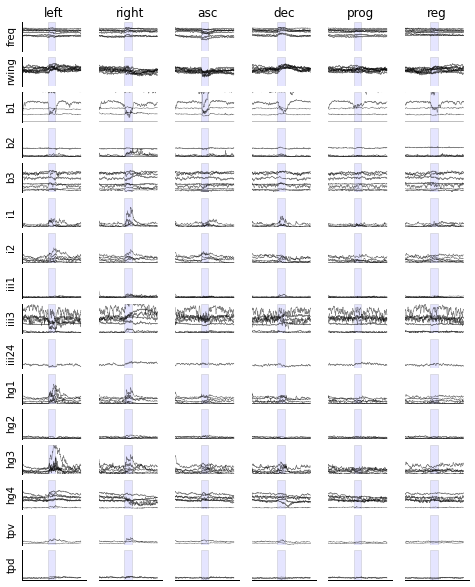

In [14]:
def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(muscles)-1):
        plb.gca().spines['bottom'].set_visible(True)
    if (r == 0):
        plb.gca().set_title(col)

    
    #plb.gca().get_xaxis().tick_bottom()
    #plb.gca().get_yaxis().tick_left()

plb.figure(figsize = (8,10))
from matplotlib.gridspec import GridSpec
gs = GridSpec(len(muscles),6)
axis_dict = dict()
for r,row in enumerate(muscles):
    axis_dict[row] = {}
    for c,col in enumerate(['left','right','asc','dec','prog','reg']):
        axis_dict[row][col] = plb.subplot(gs[r,c])
        frmt_axis(r,c,row,col)
        plb.axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'b',edgecolor = (0,0,0,0))
        
def plot_fly_dict(fly_dict):
    import numpy as np
    for sig_key in fly_dict['sig_mtrx'].keys():
        try:
            row = apodeme_map[sig_key]
            for col in ['left','right','asc','dec','prog','reg']:
                idx = fly_dict['sig_mtrx']['trial_cond'] == gd.encode[col_map[col]]
                #print row,col
                plb.axes(axis_dict[row][col])
                #print sig_key
                plb.plot(np.mean(fly_dict['sig_mtrx'][sig_key][idx],axis = 0))
        except KeyError:
            pass
        
def plot_swarm_dict(swarm_dict):
    import numpy as np

                    
    xi = np.linspace(0,23,1150)
    for fly_num in swarm_dict.keys():
        fly_dict = swarm_dict[fly_num]
        sum_data = dict()
        for sig_key in fly_dict['sig_mtrx'].keys():
            sum_data[sig_key] = dict()
            if sig_key in apodeme_map.values():
                for col in ['left','right','asc','dec','prog','reg']:
                    sum_data[sig_key][col] = list()
                
        for sig_key in fly_dict['sig_mtrx'].keys():
            try:
                for col in ['left','right','asc','dec','prog','reg']:
                    idx = fly_dict['sig_mtrx']['trial_cond'] == gd.encode[col_map[col]]
                    sum_data[sig_key][col].append(np.nanmedian(fly_dict['sig_mtrx'][sig_key][idx],axis = 0))
            except KeyError:
                pass
    
    grand_summary = dict()
    for sig_key in fly_dict['sig_mtrx'].keys():
        grand_summary[sig_key] = dict()
        if sig_key in apodeme_map.values():
            for col in ['left','right','asc','dec','prog','reg']:
                grand_summary[sig_key][col] = list()
                
    for sig_key in muscles:# sum_data.keys():
        try:
            row = apodeme_map[sig_key]
            if 'Ph0' in row:
                for col in sum_data[row].keys():
                    plb.axes(axis_dict[sig_key][col])
                    plb.plot(xi,np.rad2deg(np.nanmedian(sum_data[row][col],axis = 0)/5.0),color = 'k',alpha = 0.5,lw = 0.5)
                    plb.gca().set_ybound(0,90)
                    grand_summary[row][col].append(np.nanmedian(sum_data[row][col],axis = 0)/5.0)
            elif 'wb_frequency' in row:
                for col in sum_data[row].keys():
                    plb.axes(axis_dict[sig_key][col])
                    #ubound = np.percentile(sum_data[row][col],99,axis = 0)
                    #lbound = np.percentile(sum_data[row][col],1,axis = 0)
                    #plb.fill_between(xi,lbound,ubound,alpha =0.1,facecolor = 'green')
                    plb.plot(xi,np.nanmedian(sum_data[row][col],axis = 0),color = 'k',alpha = 0.5,lw = 0.5)
                    plb.gca().set_ybound(100,250)
                    grand_summary[row][col].append(np.nanmedian(sum_data[row][col],axis = 0))
            else:
                for col in sum_data[sig_key].keys():
                    plb.axes(axis_dict[row][col])
                    #print sig_key
                    #ubound = np.percentile(sum_data[row][col],99,axis = 0)
                    #lbound = np.percentile(sum_data[row][col],1,axis = 0)
                    #plb.fill_between(xi,lbound,ubound,alpha =0.5,facecolor = 'green')
                    plb.plot(xi,np.nanmedian(sum_data[sig_key][col],axis = 0),color = 'k',alpha = 0.5,lw = 0.5)
                    plb.gca().set_ybound(0.0,1.50)
                    grand_summary[sig_key][col].append(np.nanmedian(sum_data[sig_key][col],axis = 0))
        except KeyError:
            pass
    return grand_summary

#plot_fly_dict(swarm_data['GMR22H05'].values()[3])
gsums = list()
for swarm in swarm_data.values():
    gsums.append(plot_swarm_dict(swarm))
plb.savefig('stimulus_avg.pdf')

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

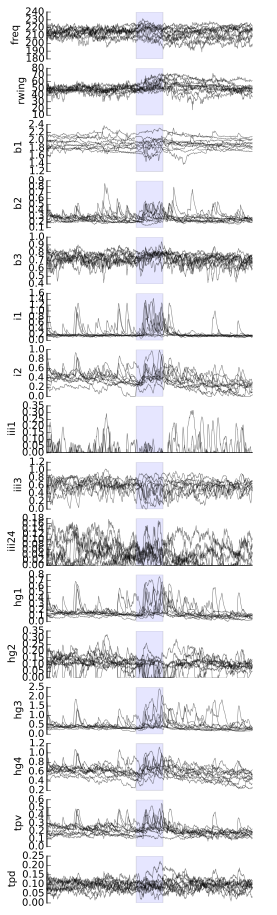

In [84]:
fig = plb.figure(figsize = (4,20))
example_fly = 5
idx = gd.encode['flow_right'] == (swarm_data['GMR22H05'].values()[3]['sig_mtrx']['trial_cond'])
plb.subplot(15,1,1)
xi = np.linspace(0,23,1150)
for i,sig_key in enumerate(muscles):
    try:
        plb.subplot(20,1,i+1)
        plb.plot(xi,swarm_data['GMR22H05'].values()[5]['sig_mtrx'][sig_key][idx][::].T,
                 color = 'k',
                 alpha = 0.5,
                 lw = 0.5)
        plb.axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'b',edgecolor = (0,0,0,0))
        plb.gca().set_ylabel(sig_key)
        plb.gca().spines['top'].set_visible(False)
        plb.gca().spines['right'].set_visible(False)
        #plb.gca().spines['left'].set_visible(False)
        plb.gca().spines['bottom'].set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        #[y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklines()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
    except KeyError:
        if 'freq' in sig_key:
            plb.plot(xi,swarm_data['GMR22H05'].values()[5]['sig_mtrx']['wb_frequency'][idx][::].T,
                     color = 'k',
                     alpha = 0.5,
                     lw = 0.5)
            plb.gca().set_ylabel('freq')
            plb.axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'b',edgecolor = (0,0,0,0))
        if 'rwing' in sig_key:
            plb.plot(xi,np.rad2deg(swarm_data['GMR22H05'].values()[5]['sig_mtrx']['Ph0'][idx][::].T/5),
                     color = 'k',
                     alpha = 0.5,
                     lw = 0.5)
            plb.gca().set_ylabel('rwing')
            plb.axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'b',edgecolor = (0,0,0,0))
        plb.gca().spines['top'].set_visible(False)
        plb.gca().spines['right'].set_visible(False)
        #plb.gca().spines['left'].set_visible(False)
        plb.gca().spines['bottom'].set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        #[y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklines()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
plb.savefig('example_traces.pdf')

['progressive',
 'flow_right',
 'ascending',
 'regressive',
 'descending',
 'flow_left']

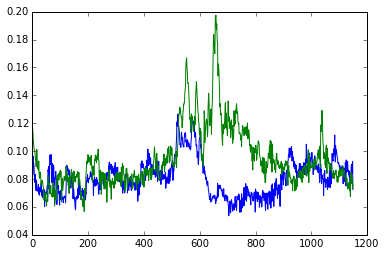

In [11]:
import numpy as np
for x in gsums:
    ln = list()
    try:
        ln.append(x['hg4']['right'][0])
    except KeyError:
        pass
plb.plot(np.mean(ln,axis = 0))
for x in gsums:
    ln = list()
    try:
        ln.append(x['hg4']['left'][0])
    except KeyError:
        pass
plb.plot(np.mean(ln,axis = 0))

 ...]

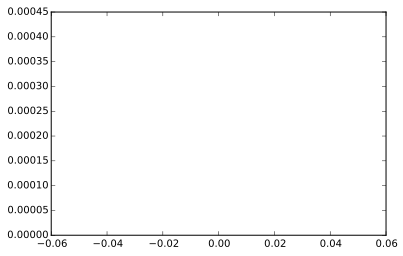

In [95]:
import numpy as np
for x in gsums:
    ln = list()
    try:
        ln.append(x['hg1']['right'])
    except KeyError:
        pass
plb.plot(np.nanmean(ln,axis = 0))
for x in gsums:
    ln = list()
    try:
        ln.append(x['hg1']['left'])
    except KeyError:
        pass
plb.plot(np.nanmean(ln,axis = 0))

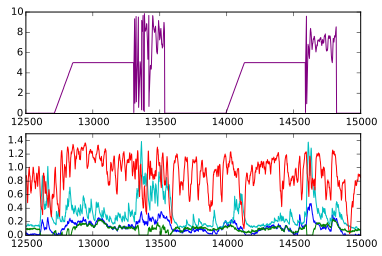

In [25]:
pltrng = np.arange(12500,15000,1)
plb.subplot(2,1,2)
#plb.plot(pltrng,sigs['b1'][pltrng],color='r')
plb.plot(pltrng,sigs['b2'][pltrng],color='b')
#plb.plot(pltrng,sigs['b3'][pltrng],color='g')
plb.plot(pltrng,sigs['i1'][pltrng],color='c')
plb.plot(pltrng,sigs['iii3'][pltrng],color='r')
#plb.plot(pltrng,sigs['iii24'][pltrng],color='c')
#plb.plot(pltrng,sigs['iii3'][pltrng],color='orange')
#plb.plot(pltrng,sigs['hg4'][pltrng],color='purple')
#plb.plot(pltrng,sigs['hg1'][pltrng],color='orange')
plb.plot(pltrng,sigs['hg2'][pltrng],color='green')
#plb.plot(pltrng,sigs['StimCond'][pltrng],color='green')
plb.gca().set_ybound(0,1.5)
plb.subplot(2,1,1)
plb.plot(pltrng,sigs['Xpos'][pltrng],color='purple')


In [124]:
import h5py

In [125]:
hf = h5py.File('/media/FlyDataC/FlyDB/Fly0308/resampled_sequences.hdf5','r')

In [126]:
data = np.array(hf['ascending']['movie_data'])

In [128]:
shape(data)

(1035, 130, 174)

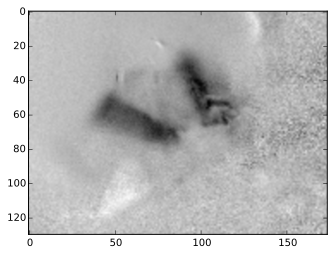

In [133]:
imshow(data[30]-data[500],cmap = cm.gray)

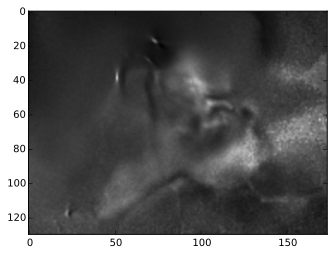

In [28]:
imshow(results[0]['Fly0308']['movie_dict']['regressive'][500],cmap = cm.gray)

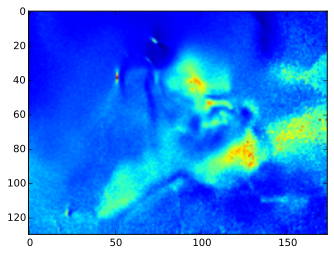

In [215]:
imshow(results[0]['Fly0308']['movie_dict']['flow_left'][0])

In [213]:
results[0]['Fly0308'].keys()

['scond_dict', 'rwing_dict', 'freq_dict', 'movie_dict']

In [22]:
swarms = [GMR22H05_swarm,
         GMR39E01_swarm,
         GMR31E10_swarm,
         GMR29E05_swarm,
         GMR22H05_GFP_swarm,
         GMR31E10_GFP_swarm,
         GMR29E05_GFP_swarm]

In [27]:
import h5py
#loop over a swarm and save the interpolated movie data
for swarm in swarms:
    for fly in swarm.flies:
        import cPickle
        try:
            movie_data,cond_data,wing_data,freq_data = get_data_DF_F(fly)
            fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','a')

            movie_group = fi.create_group('movie_data')
            for key in movie_data:
                movie_group[key] = movie_data[key]

            cond_group = fi.create_group('cond_data')
            for key in cond_data:
                cond_group[key] = cond_data[key]

            wing_group = fi.create_group('wing_data')
            for key in wing_data:
                wing_group[key] = wing_data[key]

            freq_group = fi.create_group('freq_data')
            for key in freq_data:
                freq_group[key] = freq_data[key]

            fi.flush()
            fi.close()
            print fly.fly_num
            #f = open(fly.fly_path + 'trial_data_dF_F.cpkl','wb')
            #cPickle.dump(data,f)
            #f.close()
        except (IOError,ValueError):
            print 'error'

308
309
310
311
312
error
314
315
316
317
327
328
318
319
320
321
322
323
324
325
329
330
331
332

/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:466: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]



333
error
335
336
error
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
370
371
372
373
380
381
382
383
361
362
363
364
365
384
385
386
366
367
368
369
376
377
378
379


/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_movie(fly,imgs,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    output_data = zeros((shape(imgs)[0],output_shape[0],output_shape[1]))
    for i,img in enumerate(imgs):
        X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
        output_data[i,:,:]= X_warped
    return output_data

In [33]:
def accumulate_trial_movie(fly,winput=None,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    img_data = np.array(fi['movie_data'][trial_key])
    fi.close()
    wmovie = warp_fly_movie(fly,img_data,s=0.25)
    if winput == None:
        return wmovie
    else:
        wmovie += winput
        return wmovie
    
def get_trial_wingdata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    wing_data = np.array(fi['wing_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return wing_data

def get_trial_conddata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    cond_data = np.array(fi['cond_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return cond_data

def get_trial_freqdata(fly,trial_key = None):
    fi = h5py.File(fly.fly_path + 'trial_movies.hdf5','r')
    cond_data = np.array(fi['freq_data'][trial_key])
    #print shape(fi['wing_data'][trial_key])
    fi.close()
    return cond_data

In [64]:
def get_trial_average(flies,trial_key):
    startidx = 0
    try:
        wmovie = accumulate_trial_movie(flies[startidx],trial_key = trial_key)
        wing = get_trial_wingdata(flies[startidx],trial_key = trial_key)
        freq = get_trial_freqdata(flies[startidx],trial_key = trial_key)
        cond = list([get_trial_conddata(flies[startidx],trial_key = trial_key)])
    except (IOError,KeyError):
        startidx += 1
        wmovie = accumulate_trial_movie(flies[startidx],trial_key = trial_key)
        wing = get_trial_wingdata(flies[startidx],trial_key = trial_key)
        freq = get_trial_freqdata(flies[startidx],trial_key = trial_key)
        cond = list([get_trial_conddata(flies[startidx],trial_key = trial_key)])
    
    for fly in flies[startidx+1:]:
        try:
            wmovie += accumulate_trial_movie(fly,trial_key = trial_key)
            wing += get_trial_wingdata(fly,trial_key= trial_key)
            freq += get_trial_freqdata(fly,trial_key= trial_key)
            cond.append(get_trial_conddata(fly,trial_key= trial_key))
        except (IOError,KeyError):
            print fly.fly_num
    return wmovie,rad2deg(wing/len(flies)/5.0),freq/len(flies)

#savemovie = (wmovie/np.max(wmovie.ravel())*255).astype(int32)
#import tifffile
#tifffile.imsave('29E05_%s_df_f.tif'%(trial_key),savemovie)

In [65]:
MR22H05_GFP_list = [370,371,372,373,380,381,382,383]
GMR22H05_GFP_swarm = flylib.Squadron(fly_db,GMR22H05_GFP_list)

GMR31E10_GFP_list = [361,362,363,364,365,384,385,386]
GMR31E10_GFP_swarm = flylib.Squadron(fly_db,GMR31E10_GFP_list)

GMR29E05_GFP_list = [366,367,368,369,376,377,378,379]
GMR29E05_GFP_swarm = flylib.Squadron(fly_db,GMR29E05_GFP_list)

In [60]:
#del(datadict)

In [63]:
import h5py
datadict = dict()
for group,swarm in zip(swarms.keys(),swarms.values()):
    flies = swarm.flies
    trial_key = 'flow_right'
    wmovie_right,wing_angles_right,freq_right = get_trial_average(flies,trial_key)
    trial_key = 'flow_left'
    wmovie_left,wing_angles_left,freq_left = get_trial_average(flies,trial_key)

    trial_key = 'ascending'
    wmovie_up,wing_angles_up,freq_up = get_trial_average(flies,trial_key)

    trial_key = 'descending'
    wmovie_down,wing_angles_down,freq_down = get_trial_average(flies,trial_key)

    trial_key = 'progressive'
    wmovie_for,wing_angles_for,freq_for = get_trial_average(flies,trial_key)

    trial_key = 'regressive'
    wmovie_back,wing_angles_back,freq_back = get_trial_average(flies,trial_key)

    datadict[group] = dict()
    datadict[group]['wmovie_right'] = wmovie_right
    datadict[group]['wmovie_left'] = wmovie_left

    datadict[group]['wing_angles_right'] = wing_angles_right
    datadict[group]['wing_freq_right'] = freq_right

    datadict[group]['wing_angles_left'] = wing_angles_left
    datadict[group]['wing_freq_left'] = freq_left

    datadict[group]['wmovie_ascending'] = wmovie_up
    datadict[group]['wing_angles_ascending'] = wing_angles_up
    datadict[group]['wing_freq_ascending'] = freq_up

    datadict[group]['wmovie_decending'] = wmovie_down
    datadict[group]['wing_angles_decending'] = wing_angles_down
    datadict[group]['wing_freq_decending'] = freq_down

    datadict[group]['wmovie_progressive'] = wmovie_for
    datadict[group]['wing_angles_progressive'] = wing_angles_for
    datadict[group]['wing_freq_progressive'] = freq_for

    datadict[group]['wmovie_regressive'] = wmovie_back
    datadict[group]['wing_angles_regressive'] = wing_angles_back
    datadict[group]['wing_freq_regressive'] = freq_back

313
313
313
313
313
313
334
334
334
334
334
334


In [39]:
figure()
tindexs = range(0,750,100)
from matplotlib import gridspec
for i,ind in enumerate(tindexs):
    subplot(1,len(tindexs),i+1)
    imshow(datadict['GMR22H05']['wmovie_right'][ind] -datadict['GMR22H05']['wmovie_right'][0] ,cmap = cm.gray,vmax =5)

In [67]:
from matplotlib import gridspec
cmap = cm.gray
vmin = -2.0
vmax = 8.

xmin = 60/4.0
xmax = 750/4.0
xbounds = (xmin,xmax)
ymin = 325/4.0
ymax = 900/4.0
ybounds = (ymin,ymax)

minang = 35
maxang = 60
minfreq = 190
maxfreq = 220

def make_tpoint_plot(line_name):
    tindexs = range(0,750,30)[10:-5:3]

    gs = gridspec.GridSpec(12,len(tindexs)+1)

    subplot(gs[0,0])
    plot(datadict[line_name]['wing_angles_left'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_left'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    
    subplot(gs[1,0])
    plot(datadict[line_name]['wing_freq_left'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_left'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
    
    for i,ind in enumerate(tindexs):
        subplot(gs[0:2,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_left'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_left'][ind].astype(float) - bsln.astype(float) ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

    subplot(gs[2,0])
    plot(datadict[line_name]['wing_angles_right'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_right'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    
    subplot(gs[3,0])
    plot(datadict[line_name]['wing_freq_right'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_right'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        

    for i,ind in enumerate(tindexs):
        subplot(gs[2:4,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_right'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_right'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)


    subplot(gs[5,0])
    plot(datadict[line_name]['wing_freq_ascending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_ascending'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[4,0])
    plot(datadict[line_name]['wing_angles_ascending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_ascending'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[4:6,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_ascending'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_ascending'][ind]  - bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)


    subplot(gs[7,0])
    plot(datadict[line_name]['wing_freq_decending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_decending'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[6,0])
    plot(datadict[line_name]['wing_angles_decending'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_decending'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[6:8,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_decending'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_decending'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

    subplot(gs[9,0])
    plot(datadict[line_name]['wing_freq_progressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_progressive'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[8,0])
    plot(datadict[line_name]['wing_angles_progressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_progressive'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
        
    for i,ind in enumerate(tindexs):
        subplot(gs[8:10,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_progressive'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_progressive'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)
    
    subplot(gs[11,0])
    plot(datadict[line_name]['wing_freq_regressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_freq_regressive'][ind],'o',color = 'k')
        gca().set_ybound(minfreq,maxfreq)
        
    subplot(gs[10,0])
    plot(datadict[line_name]['wing_angles_regressive'][tindexs[0]-100:tindexs[-1]+100])
    gca().set_xticklabels([])
    for ind in tindexs:
        plot(ind-tindexs[0]+100,datadict[line_name]['wing_angles_regressive'][ind],'o',color = 'k')
        gca().set_ybound(minang,maxang)
    for i,ind in enumerate(tindexs):
        subplot(gs[10:12,i+1])
        bsln = np.mean(datadict[line_name]['wmovie_regressive'][0:200],axis = 0)
        imshow(datadict[line_name]['wmovie_regressive'][ind]- bsln ,cmap = cmap,vmin = vmin,vmax = vmax)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().set_xbound(xbounds)
        gca().set_ybound(ybounds)

#for line_name in ['GMR22H05','GMR39E01','GMR31E10','GMR29E05'][0:1]:
for line_name in swarms.keys():
    figure(figsize = (8.5,11))
    make_tpoint_plot('%s'%(line_name))
    savefig('%s_tpoint_plot.pdf'%(line_name))
    suptitle(line_name)

In [50]:
imshow(bsln,cmap = cm.gray)

In [35]:
range(0,750,100)

[0, 100, 200, 300, 400, 500, 600, 700]

In [8]:
import os
import shutil
fly_folders = os.listdir('/media/FlyDataC_/FlyDB/')
for folder in fly_folders[-11:]:
    try:
        files = os.listdir('/media/FlyDataC_/FlyDB/'+folder)
        if 'fly_record.hdf5' in files:
            print folder
            shutil.copy2('/media/FlyDataC_/FlyDB/'+folder + '/' + 'fly_record.hdf5',
                         '/media/FlyDataC/FlyDB/'+folder)
    except OSError:
        print 'error'

Fly0376
Fly0377
Fly0378
Fly0379
Fly0380
Fly0381
Fly0382


In [98]:
[fl.fly_num for fl in GMR31E10_swarm.flies]

[337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348]

In [75]:
resample_times = np.arange(0,23,0.03)
stim = ((resample_times>10) & (resample_times<13))
fig = figure(figsize=(10,10))
vmax = 25
i = 0
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(11, 4)
plotitems = list()
for j in range(4):
    subplot(gs[0,j])
    plot(resample_times,stim)
    gca().set_title(datadict.keys()[j])
    subplot(gs[1,j])
    plotdict = dict()
    plot(resample_times,datadict.values()[j]['wing_angles_right'],color ='r')
    plot(resample_times,datadict.values()[j]['wing_angles_left'],color = 'b')
    plotdict['tpoint'] = plot([resample_times[i],resample_times[i]],[0,90])
    subplot(gs[2:5,j])
    plotdict['im_right'] = imshow(datadict.values()[j]['wmovie_right'][i],cmap = cm.hot,vmin = 0,vmax = vmax)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('stimulus: yaw right')
    subplot(gs[5:8,j])
    plotdict['im_left'] = imshow(datadict.values()[j]['wmovie_left'][i],cmap = cm.hot,vmin = 0,vmax = vmax)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('stimulus: yaw left')
    subplot(gs[8:11,j])
    plotdict['im_diff'] = imshow(datadict.values()[j]['wmovie_dif'][i],cmap = cm.jet,vmin = vmax*-0.1,vmax = vmax*0.1)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    if j == 0:
        gca().set_ylabel('difference')
    plotitems.append(plotdict)

In [76]:
frames = range(1,len(resample_times))
def init():
    return None

def animate(i):
    #print i
    for j in range(4):
        plotitems[j]['tpoint'][0].set_data([resample_times[i],resample_times[i]],[0,90])
        plotitems[j]['im_right'].set_data(datadict.values()[j]['wmovie_right'][i])
        plotitems[j]['im_left'].set_data(datadict.values()[j]['wmovie_left'][i])
        plotitems[j]['im_diff'].set_data(datadict.values()[j]['wmovie_dif'][i])
    #draw()
    #return [tpoint,im_right,im_left,im_diff]

In [77]:
from matplotlib import animation

In [78]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=1, blit=False)
plt.draw()
anim.save('yaw_movie_cm.mov', fps=30,extra_args=['-vcodec', 'mpeg4', '-b', '5000k' ])

In [34]:
plot((resample_times>10) & (resample_times<13))

In [33]:
resample_times>10

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [81]:
draw()

In [38]:
tifffile.imsave('22H05_%s_df_f.tif'%('diffmovie'),diffmovie)

In [63]:
def custom_warp(img,A,dest_shape):
    A_p = inv(A)
    in_x,in_y = shape(img)
    out_x,out_y = dest_shape
    out_img = np.zeros(dest_shape)
    for x_idx in range(out_x):
        for y_idx in range(out_y):
            src_x,src_y,_ = np.dot(A_p,np.array([x_idx,y_idx,1]))
            if (src_x >= 0) & (src_y >= 0) & (src_x < in_x-1) & (src_y < in_y-1):
                Q11 = img[int(src_x),int(src_y)]
                Q12 = img[int(src_x),int(src_y)+1]
                Q21 = img[int(src_x)+1,int(src_y)]
                Q22 = img[int(src_x)+1,int(src_y)+1]
                C11 = ((int(src_x)+1)-src_x) * ((int(src_y)+1)-src_y)
                C12 = ((int(src_x)+1)-src_x) * (src_y - int(src_y))
                C21 = (src_x - int(src_x)) * ((int(src_y)+1)-src_y)
                C22 = (src_x - int(src_x)) * (src_y - int(src_y))
                out_img[x_idx,y_idx] = Q11*C11 + Q12*C12 + Q21*C21 + Q22*C22
    return out_img.T

In [4]:
def warp():
    import muscle_model as mm
    confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
    confocal_view = mm.ModelViewMPL(confocal_model)
    testfly = GMR22H05_swarm.flies[0]
    flydir = testfly.fly_path
    imgs = testfly.experiments.values()[0].exp_record['tiff_data']['images']
    print shape(imgs)
    import cv2
    import cPickle
    pkname = testfly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    import clwarp as clw
    reload(clw)
    s = 0.5 #scale factor
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    return clw.opencl_warp(imgs[:1000],Ap,output_shape)

###warp the fly data

In [35]:
testfly = GMR22H05_swarm.flies[0]
flydir = testfly.fly_path
imgs = testfly.experiments.values()[0].exp_record['tiff_data']['images']
num_frames = shape(imgs)[0]
output_shape = (num_frames,1024/4,1024/4)
import h5py
#warped_movie_file = h5py.File(flydir + 'warped_movie_compressed.hdf5')
#dset = warped_movie_file.create_dataset('images',(output_shape),compression = "gzip")
def warp_fly_movie(fly,input_dset,output_dset):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    src_p0 = test_basis['a1'] + test_basis['p']
    src_p1 = test_basis['p']
    src_p2 = test_basis['a2'] + test_basis['p']
    dst_p0 = confocal_basis['a1'] + confocal_basis['p']
    dst_p1 = confocal_basis['p']
    dst_p2 = confocal_basis['a2'] + confocal_basis['p']
    A = cv2.getAffineTransform(np.float32([src_p0,src_p1,src_p2]),np.float32([dst_p0,dst_p1,dst_p2]))
    #compose to smaller image size
    A = vstack((A,[0,0,1]))
    S = np.array([[0.25,0,0],[0,0.25,0],[0,0,1]])
    Ap = dot(S,A)[:2,:3]
    for i in range(shape(input_dset)[0])[:30:10]:
        idxs = range(i,i+10)
        frames = [np.array(imgs[x]) for x in idxs]
        print idxs
        #X_warped = cv2.warpAffine(img.T,Ap,(1024/4,1024/4))
        #output_dset[i] = X_warped
        #if not(mod(i,100)):
        #    print i
    #testmovie = np.array(fly.fly_record['experiments'].values()[0]['tiff_data']['images'])
    #n = shape(testmovie)[0]
    #X_warped = [cv2.warpAffine(testmovie[frame].T,Ap,(256,256)).ravel() for frame in range(n)]
    #X_warped = np.array(X_warped)
    #import h5py
    #f = h5py.File(fly.fly_path + "warped_imgs.hdf5", "w")
    #f.create_group("warped_imgs")
    #f['warped_imgs'] = X_warped
    #f.flush()
    #f.close()

In [36]:
warp_fly_movie(testfly,imgs,dset)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [26]:
#import os
#for swarm in swarms:
#    for fly in swarm.flies:
#        try:
#            os.remove(fly.fly_path + 'trial_movies.hdf5')
#        except OSError:
#            print fly.fly_num

308
309
310
311
312
313
314
315
316
317
327
328
318
319
320
321
322
323
324
325
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
370
371
372
373
380
381
382
383
361
362
363
364
365
384
385
386
366
367
368
369
376
377
378
379


In [4]:
import cPickle
test_group = [308,309,310,311,312,313,314]
swarm = flylib.Squadron(fly_db,test_group)
for fly in swarm.flies:
    f = open(fly.fly_path + 'img_stats.cpkl','rb')
    stats = cPickle.load(f)
    f.close()
    figure()
    imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)

In [13]:
import cPickle
qui_ranges = dict()
qui_ranges[308] = slice(400,600)
qui_ranges[309] = slice(300,400)
qui_ranges[310] = slice(500,600)
qui_ranges[311] = slice(320,380)
qui_ranges[312] = slice(500,600)
qui_ranges[313] = slice(550,600)

qui_ranges[314] = slice(1,300)
qui_ranges[315] = slice(200,400)
qui_ranges[316] = slice(400,600)
qui_ranges[317] = slice(300,500)

def calc_fly(fly):
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    
    musc = GeometricModel(muscles,confocal_basis)
    mv = ModelView(musc)

    imgs = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
    masks = mv.get_masks(test_basis)

    #create the model and project it onto the data
    mproject = sum([np.array(m).reshape(174,130).astype(float) for m in masks.values()],axis = 0)
    img_prime = imgs.T.reshape(174*130,-1)

    W = np.array([m.astype(float) for m in masks.values()]).T
    W_inv = np.linalg.pinv(W)

    sigs = dot(W_inv,img_prime)

    qui_range =qui_ranges[fly.fly_num]
    F = mean(sigs[:,qui_range],axis = 1)
    DF_F = (sigs-F[:,np.newaxis])/F[:,np.newaxis]
    DF_F_dict = dict()
    for i,mkey in enumerate(masks.keys()):
        DF_F_dict[mkey] = DF_F[i,:]
    f = open('f_' + str(fly.fly_num) + '_sig_dict.cpkl','wb')
    cPickle.dump(DF_F_dict,f)
    f.close()
    
for fly in swarm.flies:
    calc_fly(fly)

ImportError: cannot import name mpi4py

In [4]:
from mpi4py import MPI

ImportError: No module named mpi4py

In [110]:
sum_images = wing_correlations(wbf[mask],imgs[mask])

In [139]:
close('all')

In [39]:
musc = GeometricModel(muscles,confocal_basis)

In [41]:
mv = ModelView(musc)

In [67]:
plot(musc.lines['iii3'][0],musc.lines['iii3'][1])

In [48]:
msks = mv.get_masks(confocal_basis)

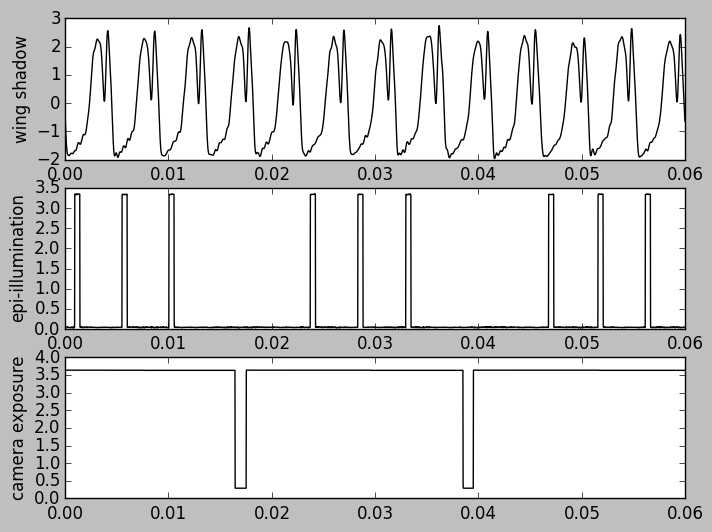

In [13]:
#plot the timing diagram for the led pulse protocol
fly = GMR22H05_swarm.flies[-1]
expmnt = fly.experiments.values()[0]
sigs = expmnt.exp_record['axon_data']
rng = slice(3004000,3007000)
tms = sigs['times'][rng]
tms -= tms[0]
subplot(3,1,1)
plot(tms,sigs['RightWing'][rng],color = 'k');gca().set_ylabel('wing shadow')
gca().set_ybound(-2,3)
subplot(3,1,2,sharex = gca())
plot(tms,sigs['Photostim'][rng],color = 'k');gca().set_ylabel('epi-illumination')
subplot(3,1,3,sharex = gca())
plot(tms,sigs['CamSync'][rng],color = 'k');gca().set_ylabel('camera exposure')
display(gcf());close()
#plot the timing diagram for the led pulse protocol
fly = GMR22H05_swarm.flies[-1]
expmnt = fly.experiments.values()[0]
sigs = expmnt.exp_record['axon_data']
rng = slice(0,3000)
tms = sigs['times'][rng]
tms -= tms[0]
subplot(3,1,1)
plot(tms,sigs['RightWing'][rng],color = 'k');gca().set_ylabel('wing shadow')
gca().set_ybound(-2,3)
subplot(3,1,2,sharex = gca())
plot(tms,sigs['Photostim'][rng],color = 'k');gca().set_ylabel('epi-illumination')
subplot(3,1,3,sharex = gca())
plot(tms,sigs['CamSync'][rng],color = 'k');gca().set_ylabel('camera exposure')
display(gcf());close()

In [59]:
imshow(msks['b2'].reshape(174,130))

In [54]:
sqrt(shape(msks['iii24']))

array([ 150.39946808])

In [33]:
import cPickle
fly = swarm.flies[2]
pkname = fly.fly_path + '/basis_fits.cpkl'
f = open(pkname);img_data = cPickle.load(f);f.close()
test_basis = Basis()
#print data.keys()
for key in ['A','p','a1','a2']:
    test_basis[key] = img_data[key]
imgs = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
masks = mv.get_masks(test_basis)

In [34]:
imshow(imgs[5000].T,cmap = cm.gray)
mv.plot(test_basis)

In [35]:
#create the model and project it onto the data
mproject = sum([np.array(m).reshape(174,130).astype(float) for m in masks.values()],axis = 0)
img_prime = imgs.T.reshape(174*130,-1)

In [36]:
W = np.array([m.astype(float) for m in masks.values()]).T
W_inv = np.linalg.pinv(W)

In [37]:
sigs = dot(W_inv,img_prime)

In [38]:
plot(sigs.T)

In [97]:
#plot(mproject.T.ravel())
#figure()
#plot(imgs[0].ravel())
#figure()
#plot(img_prime[:,30])
#imshow(imgs[0]*mproject[::-1,::-1])

In [13]:
import cPickle
import cv2

In [15]:
fly = swarm.flies[-4]

In [16]:
warp_fly_movie(fly)

In [14]:
#this block will load the metadata and warp the images/movies into a common reference frame.
def warp_fly_movie(fly):
    #fname = fly.fly_path + 'meta_data.cpkl'
    #f = open(fname,'rb');data = cPickle.load(f);f.close()
    pkname = fly.fly_path + '/basis_fits.cpkl'
    f = open(pkname);img_data = cPickle.load(f);f.close()
    test_basis = Basis()
    #print data.keys()
    for key in ['A','p','a1','a2']:
        test_basis[key] = img_data[key]
    src_p0 = test_basis['a1'] + test_basis['p']
    src_p1 = test_basis['p']
    src_p2 = test_basis['a2'] + test_basis['p']
    dst_p0 = confocal_basis['a1'] + confocal_basis['p']
    dst_p1 = confocal_basis['p']
    dst_p2 = confocal_basis['a2'] + confocal_basis['p']
    A = cv2.getAffineTransform(np.float32([src_p0,src_p1,src_p2]),np.float32([dst_p0,dst_p1,dst_p2]))
    #compose back to Ca image size
    A = vstack((A,[0,0,1]))
    S = np.array([[0.25,0,0],[0,0.25,0],[0,0,1]])
    Ap = dot(S,A)[:2,:3]
    testmovie = np.array(fly.fly_record['experiments'].values()[0]['tiff_data']['images'])
    n = shape(testmovie)[0]
    X_warped = [cv2.warpAffine(testmovie[frame].T,Ap,(256,256)).ravel() for frame in range(n)]
    X_warped = np.array(X_warped)
    import h5py
    f = h5py.File(fly.fly_path + "warped_imgs.hdf5", "w")
    #f.create_group("warped_imgs")
    f['warped_imgs'] = X_warped
    f.flush()
    f.close()
    import tifffile
    tifffile.imsave(fly.fly_path + "warped_movie.tiff",X_warped.reshape(shape(X_warped)[0],256,256))